In [1]:
import requests
import json

class WeatherGetter(object):
    
    def __init__(self):
        self.secret_key = "5bb1630466e38b8c313bed6e9de991ce"
        self.berlin_lat = "52.5200"
        self.berlin_long = "13.4050"
        self.url_base = "https://api.darksky.net/forecast"
        self.exclude = 'currently,flags,minutely,hourly,alerts'
        
    def get_weather_data_for_date(self, datetime_string, verbose=True):
        
        year, month, day = self.format_datetime(datetime_string)
        
        datetime = "{}-{}-{}T12:00:00".format(year, month, day)
        full_url = "{}/{}/{},{},{}?exclude={}".format(self.url_base, self.secret_key, 
                                                     self.berlin_lat, self.berlin_long, 
                                                     datetime, self.exclude)
        response = requests.get(full_url)
        if response.status_code == 200:
            if verbose:
                print(response.status_code)
            return response
        else: 
            raise ValueError("Error getting data from DarkSky API: Response Code {}".format(response.status_code))
            
    def was_raining(self, response, verbose=True):
        data = json.loads(response.text)
        daily = data['daily']
        data =  daily['data']
        data = data[0]
        if data['icon'] == 'rain':
            if verbose:
                print(data['icon'])
            return True
        else:
            if verbose:
                print(data['icon'])
            return False
    
    def format_datetime(self, datetime_string):
        year = datetime_string[:4]
        month = datetime_string[5:7]
        day = datetime_string[8:]
        
        return year, month, day
    
    def did_rain_on_date(self, datetime_string):
        
        response = self.get_weather_data_for_date(datetime_string, verbose=False)
        did_rain = self.was_raining(response, verbose=False)
        
        return did_rain
    
    def get_weather_for_all_dates(self, dates_list):
        """Expects input of dates in yyyy-mm-dd format
        
        Returns a dictionary where each date is the key. Rain days have a value of True, all others are False"""
        
        weather_dict = {}
        
        for date in dates_list:
            weather_dict[date] = self.did_rain_on_date(date)
        
        return weather_dict

In [2]:
wg = WeatherGetter()
wg.did_rain_on_date('2019-01-03')

False

In [3]:
import sqlite3
import pandas as pd
import numpy as np

conn = sqlite3.connect('''database.sqlite''')
cur = conn.cursor()

In [4]:
cur.execute('''select * from matches where season = 2011''')

matches = pd.DataFrame(cur.fetchall())
matches.columns = [i[0] for i in cur.description]
matches.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [5]:
# Get number of unique dates for 2011 season, so that we don't have to repeat API calls for the same dates
unique_dates = matches.Date.unique()
print("# of Unique Game Dates in 2011 Season: {}".format(len(unique_dates)))

# of Unique Game Dates in 2011 Season: 165


In [8]:
# Get rain status for each unique date in 2011 season
rain_dates = wg.get_weather_for_all_dates(unique_dates)

KeyError: 'icon'

In [9]:
rain_dates

NameError: name 'rain_dates' is not defined

In [10]:
# Create boolean column called 'Rain_Game' for the matches dataframe using the dictionary of values. 
rain_game = []
for date in matches.Date:
    rain_game.append(rain_dates[date])

matches['Rain_Game'] = rain_game
matches

NameError: name 'rain_dates' is not defined

In [11]:
## Get all unique teams, and then create a basic data dictionary for each.
## These values will be updated as we go through each match in the matches table. 

all_teams = matches['HomeTeam'].unique()
print("# of Unique Teams: {}".format(len(all_teams)))
teams_data = {}
for team in all_teams:
    data = {'total_matches_2011': 0, 
           'total_wins_2011': 0,
           'total_losses_2011': 0,
           'rain_wins_2011': 0,
           'rain_losses_2011': 0,
           'total_goals_2011': 0}
    teams_data[team] = data
print(len(teams_data))

# of Unique Teams: 56
56


In [12]:
def update_team_data(row):
    # Get goal and win data from row
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']
    datetime = row['Date']
    year = datetime[:4]
    home_did_win = False
    away_did_win = False
    
    is_rain_game = row['Rain_Game']
    
    # Determine Winner and Loser of Match
    if row['FTR'] == 'H':            # CASE: Home Win, Away Loss
        home_did_win = True
        away_did_win = False
    elif row['FTR'] == 'A':          # CASE: Home Loss, Away Win
        home_did_win = False
        away_did_win = True
    else:                            # CASE: Draw
        home_did_win = False
        away_did_win = False
    
    # Update records for home team
    update_team_win_loss_record(home_team, home_goals, home_did_win, year, is_rain_game)
    
    # Update records for away team
    update_team_win_loss_record(away_team, away_goals, away_did_win, year, is_rain_game)
    
def update_team_win_loss_record(team_name, goals, did_win, year, is_rain_game):
    team = teams_data[team_name]
    team['total_matches_2011'] += 1
    if did_win == True:
        team['total_wins_2011'] += 1
        if is_rain_game == True:
            team['rain_wins_2011'] += 1
    else:
        team['total_losses_2011'] += 1
        team['rain_losses_2011'] += 1
    team['total_goals_2011'] += goals

In [13]:
matches.apply(update_team_data, axis=1)
print(teams_data)

KeyError: ('Rain_Game', 'occurred at index 0')

In [14]:
import pymongo

class MongodbHandler(object):
    
    def __init__(self):
        """NOTE: MongoDB server must already be running before an object from this class is initialized--otherwise, 
        connecting to the client will fail!"""
        
        self.myclient = pymongo.MongoClient('mongodb://localhost:27017')
        self.db = self.myclient['section_16_lab_db']
        self.coll = self.db['section_16_lab_collection']
    
    def format_data(self, team_name, goals_2011, wins_2011, viz, rain_win_pct):
        data = {"team_name": team_name,
               "goals_2011": goals_2011,
               "wins_2011": wins_2011,
               "win_loss_histogram": viz,
               "rain_win_pct": rain_win_pct}
        
        return data
    
    def insert_record(self, record):
        
        return self.coll.insert_one(data)

ModuleNotFoundError: No module named 'pymongo'

0
0
(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), <a list of 10 Patch objects>)


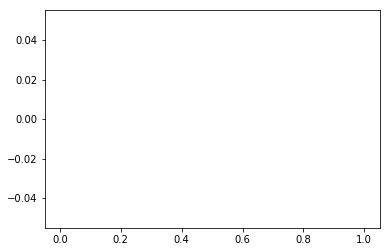

In [15]:
# Write a function to create data visualization for storage

import matplotlib.pyplot as plt
%matplotlib inline

def get_hist(team, show_viz=False):
    expanded_wl_data = []
    print(team['total_wins_2011'])
    print(team['total_losses_2011'])
    for i in range(team['total_wins_2011']):
        expanded_wl_data.append('Win')
    for i in range(team['total_losses_2011']):
        expanded_wl_data.append('Loss')
    hist = plt.hist(expanded_wl_data)
    
    if show_viz:
        plt.show()
    
    return hist

print(get_hist(teams_data['Nurnberg']))

In [16]:
# Final Step: add everything to mongoDB!

db = MongodbHandler()


for team_name, data in teams_data.items():
    if data['rain_wins_2011'] == 0 and data['rain_losses_2011'] == 0:
        rain_win_pct = "N/A"
    else:
        total_rain_games = data['rain_wins_2011'] + data['rain_losses_2011']
        rain_win_pct = str(data['rain_wins_2011'] / total_rain_games)
    
    viz = get_hist(data)
    
    record = db.format_data(team_name, data['total_goals_2011'], data['total_wins_2011'], viz, rain_win_pct)
    db.insert_record(record)
    
    # delete viz object, so that a new one is created each time. Otherwise, it will just keep updating the first one instead
    # of creating new correct visualizations
    del(viz)
    

NameError: name 'MongodbHandler' is not defined